In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import  train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [2]:
df = pd.read_csv('ai_job_dataset.csv')
df

,job_id,job_title,salary_usd,salary_currency,experience_level,employment_type,company_location,company_size,employee_residence,remote_ratio,required_skills,education_required,years_experience,industry,posting_date,application_deadline,job_description_length,benefits_score,company_name
0,AI00001,AI Research Scientist,90376,USD,SE,CT,China,M,China,50,"Tableau, PyTorch, Kubernetes, Linux, NLP",Bachelor,9,Automotive,2024-10-18,2024-11-07,1076,5.9,Smart Analytics
1,AI00002,AI Software Engineer,61895,USD,EN,CT,Canada,M,Ireland,100,"Deep Learning, AWS, Mathematics, Python, Docker",Master,1,Media,2024-11-20,2025-01-11,1268,5.2,TechCorp Inc
2,AI00003,AI Specialist,152626,USD,MI,FL,Switzerland,L,South Korea,0,"Kubernetes, Deep Learning, Java, Hadoop, NLP",Associate,2,Education,2025-03-18,2025-04-07,1974,9.4,Autonomous Tech
3,AI00004,NLP Engineer,80215,USD,SE,FL,India,M,India,50,"Scala, SQL, Linux, Python",PhD,7,Consulting,2024-12-23,2025-02-24,1345,8.6,Future Systems
4,AI00005,AI Consultant,54624,EUR,EN,PT,France,S,Singapore,100,"MLOps, Java, Tableau, Python",Master,0,Media,2025-04-15,2025-06-23,1989,6.6,Advanced Robotics
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,AI14996,Robotics Engineer,38604,USD,EN,FL,Finland,S,Finland,50,"Java, Kubernetes, Azure",Bachelor,1,Energy,2025-02-06,2025-03-25,1635,7.9,Advanced Robotics
14996,AI14997,Machine Learning Researcher,57811,GBP,EN,CT,United Kingdom,M,United Kingdom,0,"Mathematics, Docker, SQL, Deep Learning",Master,0,Government,2024-10-16,2024-10-30,1624,8.2,Smart Analytics
14997,AI14998,NLP Engineer,189490,USD,EX,CT,South Korea,L,South Korea,50,"Scala, Spark, NLP",Associate,17,Manufacturing,2024-03-19,2024-05-02,1336,7.4,AI Innovations
14998,AI14999,Head of AI,79461,EUR,EN,FT,Netherlands,M,Netherlands,0,"Java, Computer Vision, Python, TensorFlow",PhD,1,Real Estate,2024-03-22,2024-04-23,1935,5.6,Smart Analytics


In [3]:
train_set, test_set = train_test_split(df, random_state=42, test_size = 0.2)

In [4]:
target = 'salary_usd'

Transformacion numero de habilidades/competencias

In [5]:
train_set['n_skills'] = train_set['required_skills'].apply(lambda x: len(x.split(',')))
train_set['n_skills'].value_counts()

n_skills
3    4049
4    3980
5    3971
Name: count, dtype: int64

In [6]:
test_set['n_skills'] = test_set['required_skills'].apply(lambda x: len(x.split(',')))
test_set['n_skills'].value_counts()

n_skills
4    1027
3    1001
5     972
Name: count, dtype: int64

In [7]:
train_set.company_location.value_counts()

company_location
Germany           638
Austria           631
France            629
Canada            621
Denmark           617
Switzerland       615
Sweden            607
Japan             599
Israel            598
Singapore         597
United Kingdom    597
China             595
India             594
Australia         593
Ireland           591
Netherlands       591
South Korea       588
Norway            573
United States     570
Finland           556
Name: count, dtype: int64

Columna nueva agrupada por region segun la localizacion de la compañia

In [8]:
def locality(x):
    if x in ["Germany", "Austria", "France", "Denmark", "Switzerland", "Sweden",
    "United Kingdom", "Ireland", "Netherlands", "Norway", "Finland"]:
        return 'Europa'
    elif x in ["Canada", "United States"]:
        return 'America_Norte'
    elif x in ["Japan", "Israel", "Singapore", "China", "India", "South Korea"]:
        return 'Asia'
    elif x in ['Australia']:
        return 'Oceania'
    

train_set['Region'] = train_set['company_location'].apply(locality)
test_set['Region'] = test_set['company_location'].apply(locality)

In [9]:
train_set.Region.value_counts()

Region
Europa           6645
Asia             3571
America_Norte    1191
Oceania           593
Name: count, dtype: int64

In [10]:
train_set.company_name.unique()

array(['Quantum Computing Inc', 'DataVision Ltd', 'TechCorp Inc',
       'Future Systems', 'Advanced Robotics', 'Cognitive Computing',
       'Machine Intelligence Group', 'Predictive Systems',
       'DeepTech Ventures', 'Cloud AI Solutions', 'Neural Networks Co',
       'Algorithmic Solutions', 'Digital Transformation LLC',
       'Smart Analytics', 'Autonomous Tech', 'AI Innovations'],
      dtype=object)

Transformacion de los nombres de la compañia en variable con numeros imputadas las medias por salario

In [11]:
mean_salary = train_set.groupby('company_name')['salary_usd'].mean()
train_set['company_avg_salary'] = train_set['company_name'].map(mean_salary)
test_set['company_avg_salary'] = test_set['company_name'].map(mean_salary)

<Axes: >

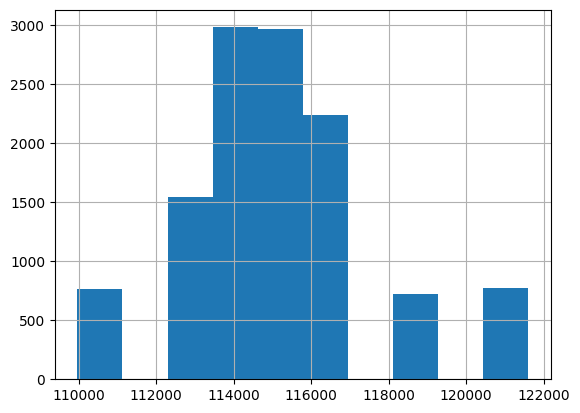

In [12]:
train_set['company_avg_salary'].hist()

Transformacion columna plazo abierto de aplicacion de la oferta de trabajo

In [13]:
train_set['posting_date'] = pd.to_datetime(train_set['posting_date'])
train_set['application_deadline'] = pd.to_datetime(train_set['application_deadline'])

train_set['plazo_oferta'] = (train_set['application_deadline'] - train_set['posting_date']).dt.days
train_set.plazo_oferta

9839     73
9680     57
7093     24
11293    32
820      30
         ..
5191     16
13418    70
5390     37
860      37
7270     22
Name: plazo_oferta, Length: 12000, dtype: int64

In [14]:
test_set['posting_date'] = pd.to_datetime(test_set['posting_date'])
test_set['application_deadline'] = pd.to_datetime(test_set['application_deadline'])

test_set['plazo_oferta'] = (test_set['application_deadline'] - test_set['posting_date']).dt.days
test_set.plazo_oferta

11499    73
6475     45
13167    47
862      19
5970     40
         ..
6216     65
3585     50
10023    28
14044    34
12965    18
Name: plazo_oferta, Length: 3000, dtype: int64

In [15]:
feat_new = ['n_skills', 'Region', 'company_avg_salary', 'plazo_oferta']

Transformacion job_title a la mediana del salario por puesto de trabajo


In [16]:
mediana = train_set.groupby('job_title')['salary_usd'].median()
train_set['job_median_salary'] = train_set['job_title'].map(mediana)
test_set['job_median_salary'] = test_set['job_title'].map(mediana)

In [17]:
feat_new.append('job_median_salary')

Transformacion de la instustria por la mediana del salario por sector

In [18]:
median = train_set.groupby('industry')['salary_usd'].median()
train_set['industry_median_salary'] = train_set['industry'].map(median)
test_set['industry_median_salary'] = test_set['industry'].map(median)

In [19]:
feat_new.append('industry_median_salary')

Codificacion para las categoricas con 2-4 valores unicos

In [20]:
dic_el = {'EN':0, 'MI': 1, 'SE':2, 'EX':3}  # orden justificado según experiencia laboral
dic_cs = {'S': 0, 'M': 1, 'L':2} # orden según el tamaño de la compañia, de menos trabajadores a más.
dic_rr = {0 : 0, 50: 1, 100:2}  # orden según si es totalmente presencial o si es 100% en remoto. La mitad es hibrido
dic_er = {'Associate' : 0, 'Bachelor': 1, 'Master': 2, 'PhD': 3} # orden establecido según escala de formación
dic_sc = {'USD' : 0, 'EUR': 1, 'GBP': 2} # orden establecido según la fuerza relativa de la moneda, siendo el dolar más débil y la libra más fuerte

train_set['experiencia'] = train_set.experience_level.map(dic_el)
train_set['tamaño_compañia'] = train_set.company_size.map(dic_cs)
train_set['modalidad'] = train_set.remote_ratio.map(dic_rr)
train_set['formacion_min'] = train_set.education_required.map(dic_er)
train_set['tipo_moneda'] = train_set.salary_currency.map(dic_sc)

test_set['experiencia'] = test_set.experience_level.map(dic_el)
test_set['tamaño_compañia'] = test_set.company_size.map(dic_cs)
test_set['modalidad'] = test_set.remote_ratio.map(dic_rr)
test_set['formacion_min'] = test_set.education_required.map(dic_er)
test_set['tipo_moneda'] = test_set.salary_currency.map(dic_sc)

In [22]:
train_set.columns

Index(['job_id', 'job_title', 'salary_usd', 'salary_currency',
       'experience_level', 'employment_type', 'company_location',
       'company_size', 'employee_residence', 'remote_ratio', 'required_skills',
       'education_required', 'years_experience', 'industry', 'posting_date',
       'application_deadline', 'job_description_length', 'benefits_score',
       'company_name', 'n_skills', 'Region', 'company_avg_salary',
       'plazo_oferta', 'job_median_salary', 'industry_median_salary',
       'experiencia', 'tamaño_compañia', 'modalidad', 'formacion_min',
       'tipo_moneda'],
      dtype='object')

In [23]:
feat_new.append('experiencia')
feat_new.append('tamaño_compañia')
feat_new.append('modalidad')
feat_new.append('formacion_min')
feat_new.append('tipo_moneda')

In [29]:
train_set['jornada'] = 0
train_set.loc[train_set['employment_type'] == 'PT', 'jornada'] = 1  #media jornada
train_set.loc[train_set['employment_type'] == 'FT', 'jornada'] = 2 

test_set['jornada'] = 0
test_set.loc[test_set['employment_type'] == 'PT', 'jornada'] = 1  
test_set.loc[test_set['employment_type'] == 'FT', 'jornada'] = 2 

train_set['Autonomo'] = (train_set['employment_type'] == 'FL').astype(int)
test_set['Autonomo'] = (test_set['employment_type'] == 'FL').astype(int)

train_set['Contrato_temporal'] = (train_set['employment_type'] == 'CT').astype(int)
test_set['Contrato_temporal'] = (test_set['employment_type'] == 'CT').astype(int)

In [30]:
feat_new.append('Contrato_temporal')
feat_new.append('Autonomo')
feat_new.append('jornada')

Separación columnas categoricas y numericas para selección 

In [26]:
feat_cat = feat_new.copy()
feat_cat.remove('plazo_oferta')
feat_num = ['years_experience', 'plazo_oferta']

In [31]:
feat_cat.append('Contrato_temporal')
feat_cat.append('Autonomo')
feat_cat.append('jornada')

In [28]:
corr = train_set[feat_num + [target]].corr()
serie_corr = np.abs(corr[target]).sort_values(ascending = False)
serie_corr

salary_usd          1.000000
years_experience    0.735575
plazo_oferta        0.008371
Name: salary_usd, dtype: float64

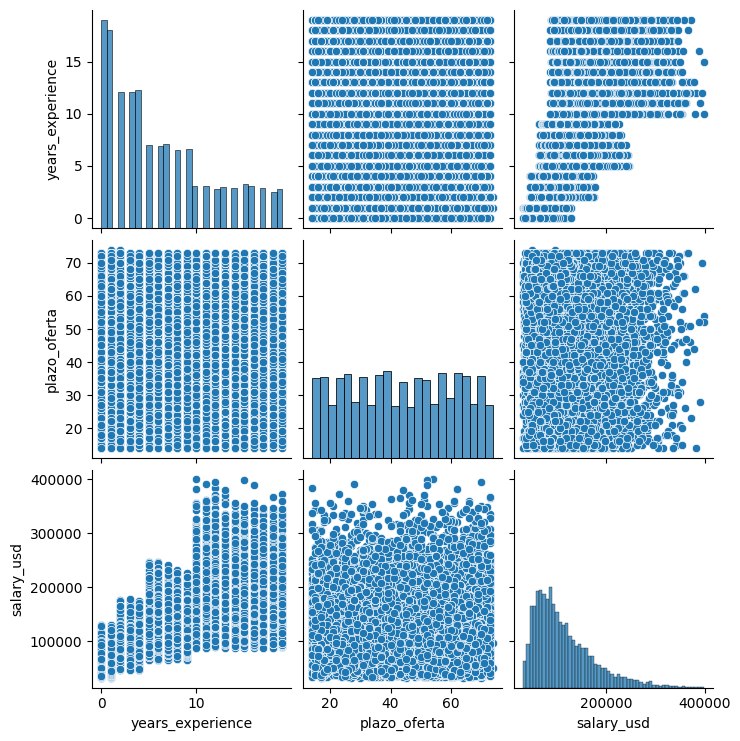

In [34]:
sns.pairplot(train_set[feat_num + [target]])

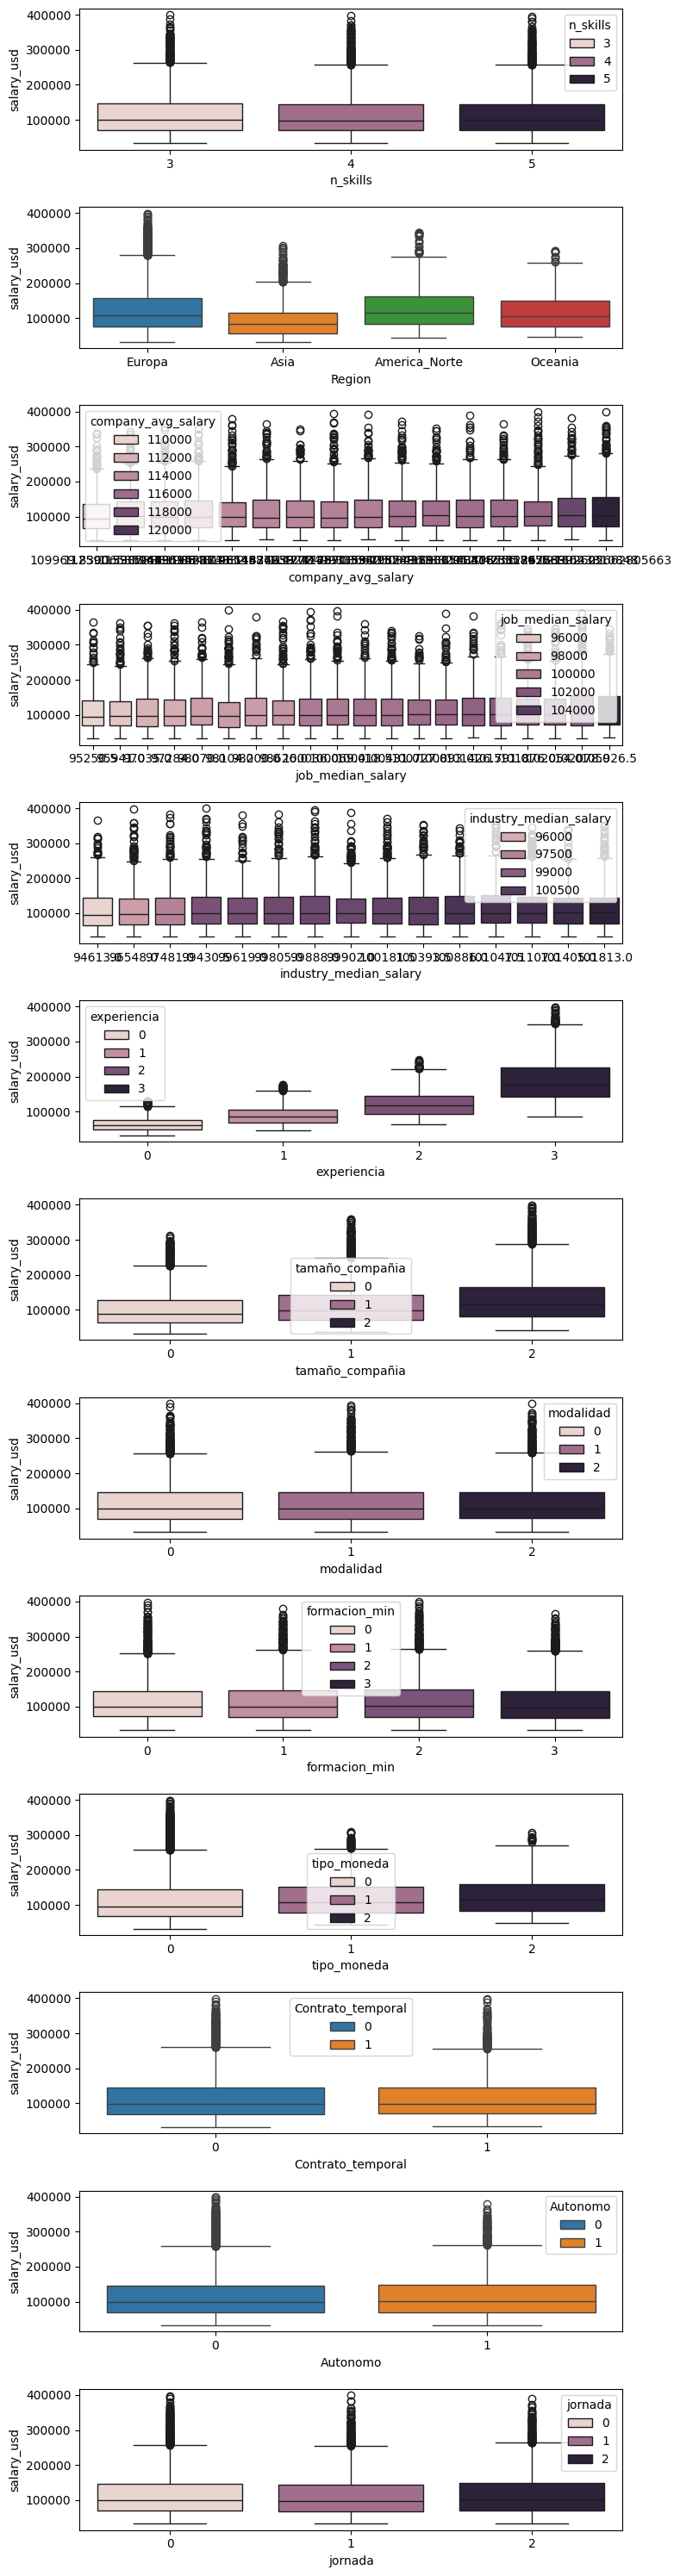

In [35]:
fig, axs = plt.subplots(nrows=len(feat_cat), ncols=1, figsize=(8,30))
n = 0
for col in feat_cat:
    sns.boxplot(x = col,
                y = target,
                hue = col,
                data=train_set,
                ax=axs[n])
    n +=1
plt.tick_params(axis='x', rotation=0)
plt.tight_layout()


In [36]:
from scipy import stats
for col in feat_cat:
        valores_unicos = train_set[col].unique()
        col_salario = [train_set[train_set[col] == categoria][target] for categoria in valores_unicos]
        f_val, p_val = stats.f_oneway(*col_salario)

        print(f"La relación de {col} con {target} tiene valor F:", f_val, "Valor p:", p_val)

La relación de n_skills con salary_usd tiene valor F: 0.4941255479863275 Valor p: 0.6101165970691849
La relación de Region con salary_usd tiene valor F: 258.7055514364074 Valor p: 1.0710559280241132e-162
La relación de company_avg_salary con salary_usd tiene valor F: 1.3775958095398708 Valor p: 0.1481393506890711
La relación de job_median_salary con salary_usd tiene valor F: 0.9211870714873572 Valor p: 0.5558856089275284
La relación de industry_median_salary con salary_usd tiene valor F: 0.6771650839731651 Valor p: 0.7990386106805354
La relación de experiencia con salary_usd tiene valor F: 6011.471489008899 Valor p: 0.0
La relación de tamaño_compañia con salary_usd tiene valor F: 252.28565232439556 Valor p: 4.733444413550363e-108
La relación de modalidad con salary_usd tiene valor F: 1.737322168281537 Valor p: 0.17603531865025565
La relación de formacion_min con salary_usd tiene valor F: 2.161926808042474 Valor p: 0.09028381378145253
La relación de tipo_moneda con salary_usd tiene valo

In [37]:
feat_sel_1 = ['years_experience', 'Region', 'experiencia', 'tamaño_compañia', 'formacion_min', 'tipo_moneda']

Transformo la columna company:location con OneHot Encoding

In [38]:
train_set = pd.get_dummies(train_set, columns=['company_location'], dtype = int)
test_set = pd.get_dummies(test_set, columns=['company_location'], dtype = int)

In [45]:
feat_new.append('years_experience')
feat_new.extend(col for col in train_set.columns if col.startswith('company') and col not in feat_new)

In [47]:
feat_new.remove('company_size')
feat_new.remove('company_name')

In [49]:
feat_cat.extend(col for col in train_set.columns if col.startswith('company') and col not in feat_cat)
feat_cat.remove('company_size')
feat_cat.remove('company_name')

Transformo la columna Region con OneHot Encoding

In [ ]:
feat_new.remove('Region')
feat_cat.remove('Region')
train_set = pd.get_dummies(train_set, columns=['Region'], dtype = int)
test_set = pd.get_dummies(test_set, columns=['Region'], dtype = int)

feat_cat.extend(col for col in train_set.columns if col.startswith('Region'))
feat_new.extend(col for col in train_set.columns if col.startswith('Region'))

In [53]:
feat_sel_1.remove('Region')
feat_sel_1.extend(col for col in train_set.columns if col.startswith('Region'))


In [55]:
dic_listas = {'lista_Borja': feat_sel_1}
dic_listas

{'lista_Borja': ['years_experience',
  'experiencia',
  'tamaño_compañia',
  'formacion_min',
  'tipo_moneda',
  'Region_America_Norte',
  'Region_Asia',
  'Region_Europa',
  'Region_Oceania']}

In [56]:
len(feat_cat)

36

Seleccion de features por ANOVA y KBest

In [57]:

from sklearn.feature_selection import SelectKBest, f_classif

'''
f_classif realiza un test ANOVA
a técnica de análisis de varianza (ANOVA) también conocida como análisis factorial y desarrollada por Fisher en 1930,
constituye la herramienta básica para el estudio del efecto de uno o más factores (cada uno con dos o más niveles) sobre
la media de una variable continua. Es por lo tanto el test estadístico a emplear cuando se desea comparar las medias de
dos o más grupos.
'''
#features_num.remove("quality")
X_train = train_set[feat_cat]
y_train = train_set[target]
selector = SelectKBest(f_classif, k=20)
x_data_kbest = selector.fit_transform(X_train, y_train)
X_train_kbest = pd.DataFrame(x_data_kbest, columns = selector.get_feature_names_out())
lista_ANOVA = X_train_kbest.columns.to_list()
lista_ANOVA.append('years_experience')
dic_listas['lista_ANOVA'] = lista_ANOVA


Seleccion de features mediante eliminacion recursiva de features RFE

In [ ]:
from sklearn.feature_selection import RFE
rf_clf = RandomForestRegressor(random_state= 42, max_depth=10)
rf_clf 

rfe = RFE(estimator = rf_clf,
          n_features_to_select= 20, # Iterará hasta quedarse con 20
          step = 1) # Elimina de una en una, pero es configurable

rfe.fit(train_set[feat_new], y_train)
print(rfe.ranking_)
pd.DataFrame(rfe.ranking_, columns= ["ranking"], index = feat_new).sort_values("ranking")

[ 3  1  1  1  1  1  1  1  2  1  6  5  4  1 18  1 15 12  1  1  7 19 13  1
 10  9 14  1  1  8  1  1 16  1 17  1  1 11]


,ranking
company_avg_salary,1
plazo_oferta,1
job_median_salary,1
industry_median_salary,1
tamaño_compañia,1
experiencia,1
modalidad,1
tipo_moneda,1
company_location_Austria,1
years_experience,1


In [65]:
X_train_rfe = pd.DataFrame(rfe.transform(train_set[feat_new]), columns = rfe.get_feature_names_out())
lista_RFE = X_train_rfe.columns.to_list()
dic_listas['lista_RFE_1'] = lista_RFE

In [ ]:
rfe = RFE(estimator = rf_clf,
          n_features_to_select= 10, # Iterará hasta quedarse con 10
          step = 1) # Elimina de una en una, pero es configurable

rfe.fit(train_set[feat_new], y_train)

X_train_rfe = pd.DataFrame(rfe.transform(train_set[feat_new]), columns = rfe.get_feature_names_out())
lista_RFE_2 = X_train_rfe.columns.to_list()
dic_listas['lista_RFE_2'] = lista_RFE_2

Seleccion Secuencial de FEatures SFS

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector

sfs_forward = SequentialFeatureSelector(rf_clf,
                                        n_features_to_select = 20,
                                        cv = 4,
                                        scoring = "neg_mean_absolute_error")


sfs_forward.fit(train_set[feat_new], y_train)




SequentialFeatureSelector(cv=4,
                          estimator=RandomForestRegressor(max_depth=10,
                                                          random_state=42),
                          n_features_to_select=20,
                          scoring='neg_mean_absolute_error')

In [70]:
X_train_sfs = pd.DataFrame(sfs_forward.transform(train_set[feat_new]), columns = sfs_forward.get_feature_names_out())
lista_sfs_1 = X_train_sfs.columns.to_list()
dic_listas['lista_SFS_1'] = lista_sfs_1

In [73]:
dic_listas.keys()

dict_keys(['lista_Borja', 'lista_ANOVA', 'lista_RFE_1', 'lista_RFE_2', 'lista_SFS_1'])

Seleccion de lista y modelo

In [75]:
model_names = ["DecisionTree","Random Forest","XGBoost","LightGBM","CatBoost"]
lr_reg = LinearRegression()
tree_reg = DecisionTreeRegressor(random_state= 42, max_depth=10)
rf_reg = RandomForestRegressor(random_state= 42, max_depth=10)
xgb_reg = XGBRegressor(random_state = 42, max_depth=10)
lgb_reg = LGBMRegressor(random_state= 42, verbose = -100, max_depth=10)
cat_reg = CatBoostRegressor(random_state= 42, verbose = False, max_depth=10)

model_set = [tree_reg, rf_reg, xgb_reg, lgb_reg, cat_reg]


In [77]:
for tipo, features in dic_listas.items():
    print(f"Para el set {tipo}:")
    for nombre,modelo in zip(model_names, model_set):
        print(f"{nombre}: ", end = " ")
        print(-np.mean(cross_val_score(modelo, train_set[features], y_train, cv = 5, scoring = "neg_mean_absolute_error")))
    print('*********')


Para el set lista_Borja:
DecisionTree:  23823.608111255628
Random Forest:  23444.237522205472
XGBoost:  24291.146484375
LightGBM:  23068.123233290633
CatBoost:  23836.786298555115
*********
Para el set lista_ANOVA:
DecisionTree:  19375.587644302388
Random Forest:  18244.279734535878
XGBoost:  19136.09765625
LightGBM:  16853.704948669543
CatBoost:  17788.200401569306
*********
Para el set lista_RFE_1:
DecisionTree:  16535.28584782324
Random Forest:  15086.13163740216
XGBoost:  15777.836328125
LightGBM:  14528.286729771551
CatBoost:  15032.6665699377
*********
Para el set lista_RFE_2:
DecisionTree:  18154.941281486164
Random Forest:  17416.277176686282
XGBoost:  20012.837109375
LightGBM:  17260.80889794754
CatBoost:  17801.27368472804
*********
Para el set lista_SFS_1:
DecisionTree:  15350.837815055385
Random Forest:  14865.416513130778
XGBoost:  14373.289453125
LightGBM:  14362.315423785429
CatBoost:  14372.960819099642
*********


- Lista ganadora lista_SFS_1 con el modelo de LightGBM

Voy a propbar con todas las features para ver la diferencia

In [78]:
for nombre,modelo in zip(model_names, model_set):
    print(f"{nombre}: ", end = " ")
    print(-np.mean(cross_val_score(modelo, train_set[feat_new], y_train, cv = 5, scoring = "neg_mean_absolute_error")))

DecisionTree:  16765.919147584038
Random Forest:  15050.867132075678
XGBoost:  15679.784375
LightGBM:  14475.497040638595
CatBoost:  14828.146149755654


In [79]:
X_train = train_set[lista_sfs_1]
y_train = train_set[target]
X_test = test_set[lista_sfs_1]
y_test = test_set[target]

In [80]:
y_train_log = np.log(y_train)
lgb_reg = LGBMRegressor(verbose = -100)

param_grid= {'max_depth': [3, 6, 10, 12],
          'learning_rate': [0.1, 0.2, 0.3, 0.4],
          'bagging_fraction': [0.3,0.6,1],
          'feature_fraction': [0.5,1],
          'n_estimators': [100, 250, 500, 750],
          'max_bins': [125,250]
          }

lgb_grid = GridSearchCV(lgb_reg, 
                        cv = 5,
                        param_grid= param_grid, 
                        scoring = "neg_mean_absolute_error",
                        n_jobs=-1)


lgb_grid.fit(X_train, y_train_log)
print("LGB best_score:", np.abs(lgb_grid.best_score_))

LGB best_score: 0.11914965178281745


In [81]:
from sklearn.metrics import  r2_score

y_pred_log = lgb_grid.best_estimator_.predict(X_test)
y_pred = np.expm1(y_pred_log)
print("MAE:", mean_absolute_error(y_test,y_pred))
print("MAPE:", mean_absolute_percentage_error(y_test,y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R^2 Score", round(r2_score(y_test, y_pred),2))

MAE: 14509.184304585855
MAPE: 0.1210654844579036
RMSE: 20066.715749397998
R^2 Score 0.89


In [82]:
features = pd.DataFrame({'Feature': X_train.columns , 'importancia': lgb_grid.best_estimator_.feature_importances_}).sort_values(by = 'importancia', ascending = False)
features['Importancia_%'] = 100* features['importancia'] / features['importancia'].sum()
features

,Feature,importancia,Importancia_%
0,experiencia,128,22.654867
1,tamaño_compañia,121,21.415929
17,company_location_United States,28,4.955752
13,company_location_Singapore,26,4.601770
18,Region_Asia,24,4.247788
3,company_location_Australia,24,4.247788
6,company_location_Denmark,23,4.070796
15,company_location_Switzerland,22,3.893805
12,company_location_Norway,21,3.716814
10,company_location_Ireland,19,3.362832


Text(0, 0.5, 'Prediction')

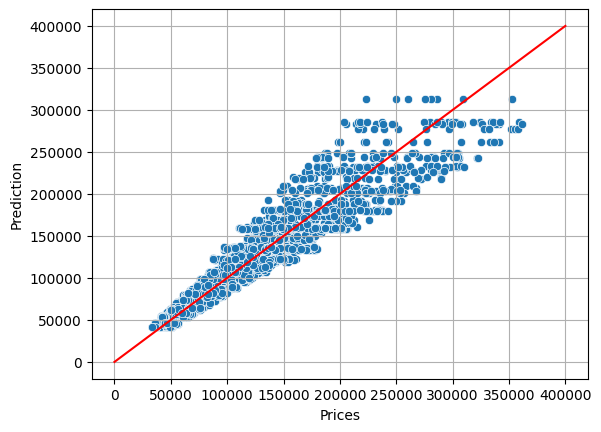

In [83]:
sns.scatterplot(x=y_test, y= y_pred) # Comprobamos valores predichos contra conocidos
plt.plot([0,400000],[0,400000],'red') # Si los valores coincidiesen con esta recta significa que no habría error en las predicciones
plt.grid()
plt.xlabel('Prices')
plt.ylabel('Prediction')

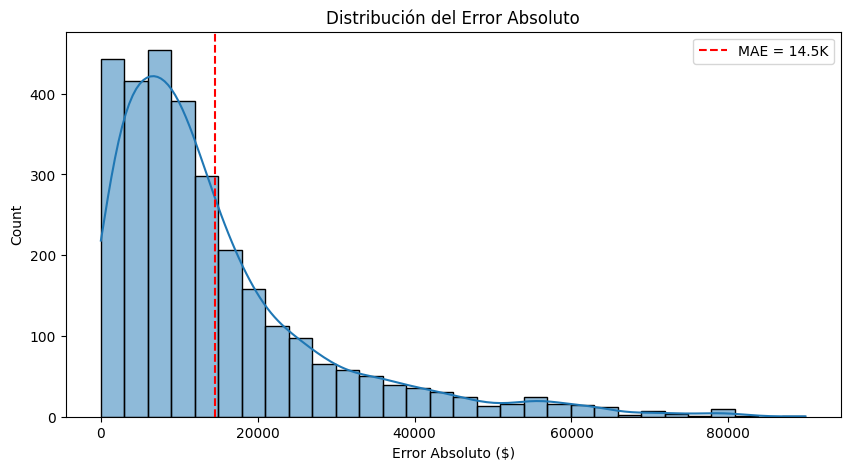

In [84]:
error_absoluto = np.abs(y_test - y_pred)
plt.figure(figsize=(10,5))
sns.histplot(error_absoluto, bins=30, kde=True)
plt.axvline(14500, color='red', linestyle='--', label='MAE = 14.5K')
plt.title('Distribución del Error Absoluto')
plt.xlabel('Error Absoluto ($)')
plt.legend()
plt.show()

In [85]:
np.abs(y_test - y_pred).describe(percentiles=[.25, .5, .75, .9, .95, .99])

count     3000.000000
mean     14509.184305
std      13864.368913
min          0.554960
25%       5224.253503
50%      10432.044100
75%      18642.400430
90%      33002.309043
95%      43981.620907
99%      63650.842903
max      89824.592720
Name: salary_usd, dtype: float64

Vamos a probar con Optuna

In [ ]:
import optuna

def objective(trial):
    # Hiperparámetros a optimizar (elige 4 o 5)
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3,6, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    model = LGBMRegressor(**params)
    score = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
    return -np.mean(score)

# Crea el estudio de Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100) 

# Muestra los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:")
print(study.best_params)

# Entrena el modelo final
best_model = LGBMRegressor(**study.best_params)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
print(f"MAE en test: {mae:.2f}")

[I 2025-06-26 12:23:44,262] A new study created in memory with name: no-name-625678e5-1885-4e41-a4a5-699f86bf2eaa
C:\Users\MARTA\AppData\Local\Temp\ipykernel_17704\412068167.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'max_depth': trial.suggest_int('max_depth', 3,6, 15),
c:\Users\MARTA\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:702: UserWarning: The distribution is specified by [3, 6] and step=15, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
[I 2025-06-26 12:23:44,523] Trial 0 finished with value: 14358.8600709

Mejores hiperparámetros:
{'n_estimators': 627, 'learning_rate': 0.10347651029305552, 'num_leaves': 39, 'max_depth': 3, 'min_child_samples': 96}
MAE en test: 14486.86


aplicando logaritmo al target

In [89]:
import optuna

def objective(trial):
    # Hiperparámetros a optimizar (elige 4 o 5)
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3,6, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    model = LGBMRegressor(**params)
    score = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
    return -np.mean(score)

# Crea el estudio de Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100) 

# Muestra los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:")
print(study.best_params)

# Entrena el modelo final
best_model = LGBMRegressor(**study.best_params)
best_model.fit(X_train, y_train_log)
y_pred_log = best_model.predict(X_test)
y_pred = np.expm1(y_pred_log)

mae = mean_absolute_error(y_test, y_pred)
print(f"MAE en test: {mae:.2f}")

[I 2025-06-26 12:29:23,770] A new study created in memory with name: no-name-f5b7d7c0-68bd-4e96-9236-2ef3976afd8d
C:\Users\MARTA\AppData\Local\Temp\ipykernel_17704\3237209230.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'max_depth': trial.suggest_int('max_depth', 3,6, 15),
c:\Users\MARTA\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:702: UserWarning: The distribution is specified by [3, 6] and step=15, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
[I 2025-06-26 12:29:24,535] Trial 0 finished with value: 14353.938455

Mejores hiperparámetros:
{'n_estimators': 741, 'learning_rate': 0.08434134915063875, 'num_leaves': 263, 'max_depth': 3, 'min_child_samples': 95}
MAE en test: 14476.42
